<a href="https://colab.research.google.com/github/DiegoPincheiraIb/Experiencias_EL5206/blob/master/Lab_Vinos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones preliminares

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import random
from random import randint
from pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tabulate import tabulate
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


# Cargar los Datos

In [2]:
df = pd.read_csv("http://www.forecastingbook.com/mooc/AustralianWines.csv?attredirects=0&d=1")
df.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


Se separa el dataframe en tipos de vinos

In [3]:
fortified = df[['Month','Fortified']]
red = df[['Month','Red ']]
rose = df[['Month','Rose ']]
sparkling = df[['Month','sparkling ']]
sweet_white = df[['Month','Sweet white']]
dry_white = df[['Month','Dry white']]

Se verifica si existen datos nulos

In [4]:
print(fortified.isnull().sum(),
      red.isnull().sum(),
      rose.isnull().sum(),
      sparkling.isnull().sum(),
      sweet_white.isnull().sum(),
      dry_white.isnull().sum()
     )

Month        0
Fortified    0
dtype: int64 Month    0
Red      0
dtype: int64 Month    0
Rose     0
dtype: int64 Month         0
sparkling     0
dtype: int64 Month          0
Sweet white    0
dtype: int64 Month        0
Dry white    0
dtype: int64


Si bien no se presentan datos nulos, se destaca la presencia de dos valores marcados como "*" en "rose". Estos se reemplazarán por un valor aleatorio dentro de la desviación estándar de la media más adelante, utilizando la función Reemplazo_Asteriscos() diseñada en el próximo apartado.

# 2.1: Análisis por tipos de vinos

## Funciones para las predicciones

Se modifica un Dataframe objetivo para que tenga los meses en formato "AAAA-MM-DD". A su vez, se imprime el gráfico de comportamiento, y se descompone el modelo en gráficos que permiten observar su tendencia (Trend), comportamiento estacional (Seasonal), y el ruido presente (Residual).

In [5]:
def Reordenamiento_Meses(DF_Obj, Str_Variable):
  DF_Obj = DF_Obj.groupby('Month')[Str_Variable].sum().reset_index()
  DF_Obj['Month'] = pd.to_datetime(DF_Obj['Month'])
  DF_Obj = DF_Obj.set_index('Month')
  Y_DF_Obj = DF_Obj[Str_Variable].resample('MS').mean()
  Y_DF_Obj.plot(figsize=(18, 8))
  plt.show()
  rcParams['figure.figsize'] = 18, 8
  Decomposition = sm.tsa.seasonal_decompose(Y_DF_Obj, model='additive')
  fig = Decomposition.plot()
  plt.show()
  return Y_DF_Obj

Esta función, dado una serie objetivo, y un booleano opcional, evalua combinaciones de parámetros del método SARIMA, entregando la combinación que da el valor mínimo de AIC, en conjunto con el valor de este. Mediante el booleano opcional es posible imprimir todas las combinaciones si este es igual a True.

In [6]:
def SARIMA_Param(Y_Obj, Show_All = False):
  Min = ''
  Valor_Min = 9999999999999
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              if Show_All:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
              if results.aic <= Valor_Min:
                Valor_Min = results.aic
                Min = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
          except:
              continue
  print('Minimo: ', Min)

Esta función realiza las predicciones.

In [7]:
def Predicciones(Y_Obj, Orden_Obj, Seas_Orden_Obj):
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  print(results.summary().tables[1])
  results.plot_diagnostics(figsize=(18, 8))
  plt.show()
  pred = results.get_prediction(start = -24,end = len(y_fortified) + 11, dynamic=False)
  pred_ci = pred.conf_int()
  ax = Y_Obj['1984':].plot(label='Observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Fortified Sales')
  plt.legend()
  plt.show()
  y_forecasted = pred.predicted_mean
  y_truth = y_fortified['1994-11-01':]
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


In [8]:
def Reemplazo_Asteriscos(DF_Obj, Str_Obj):
  DF_Obj_Copia = DF_Obj.copy()
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace('\*', np.nan, regex=True)
  Aux = DF_Obj_Copia[Str_Obj][160:180].dropna().astype(int)
  Media = Aux.mean()
  STD = Aux.std()
  Value = Media + (randint(-int(STD),int(STD)))
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace(np.nan, Value, regex=True).astype(int)
  return DF_Obj_Copia

## Fortified

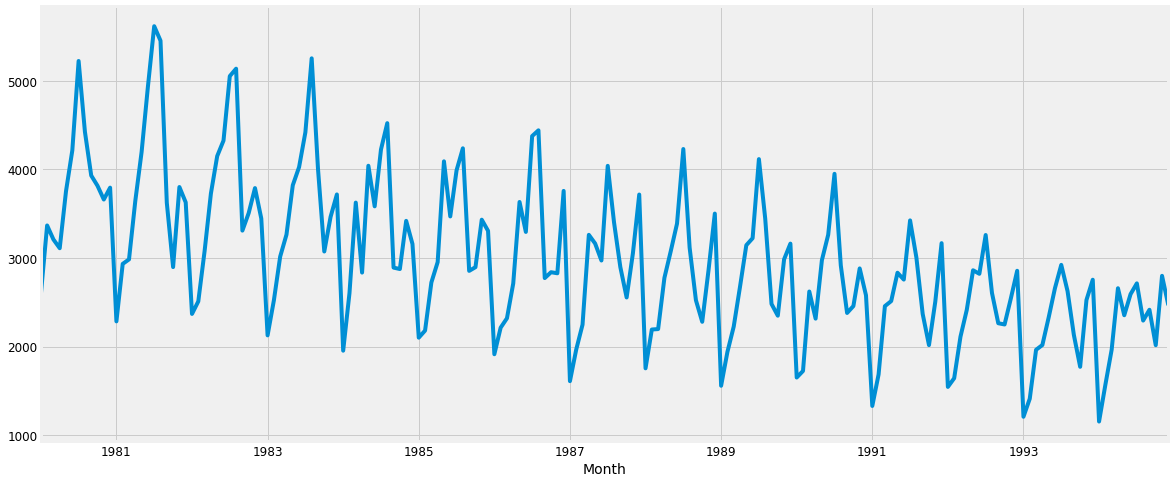

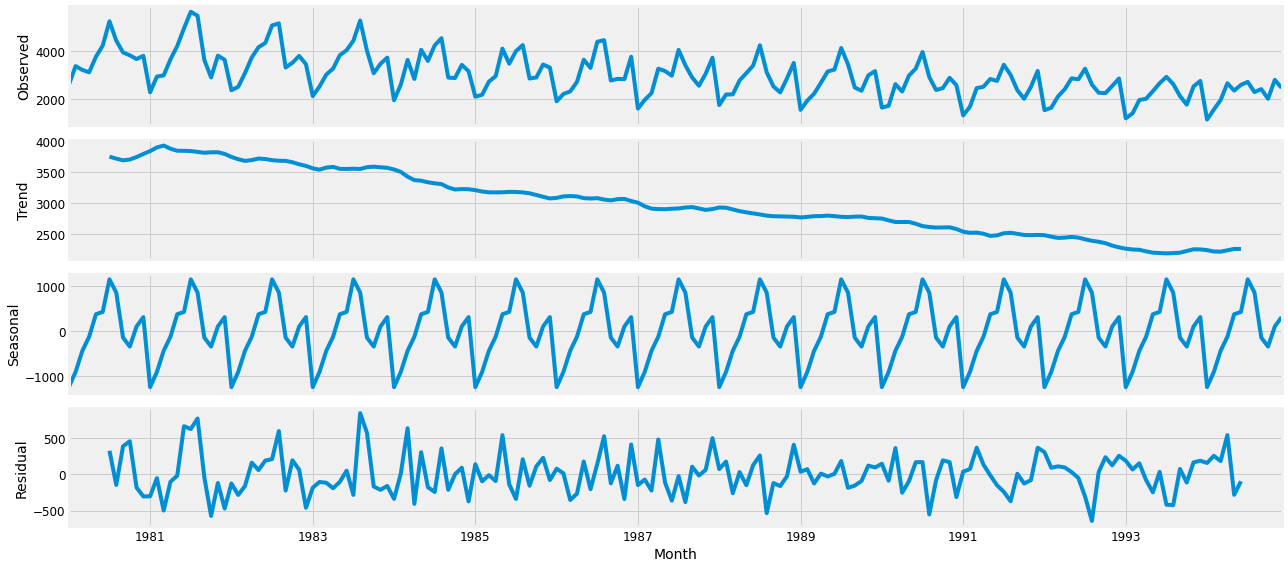

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2169.0164995610994


In [9]:
y_fortified = Reordenamiento_Meses(fortified, 'Fortified')
SARIMA_Param(y_fortified)

Los resultados anteriores indican que los parámetros más cercanos al modelo consisten en ARIMA(0, 1, 1)x(1, 1, 1, 12)12, con AIC:2169.0164995610994.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0147      0.043    -23.357      0.000      -1.100      -0.930
ar.S.L12       0.0486      0.029      1.702      0.089      -0.007       0.105
ma.S.L12      -0.5260      0.072     -7.274      0.000      -0.668      -0.384
sigma2      7.587e+04   9527.400      7.963      0.000    5.72e+04    9.45e+04


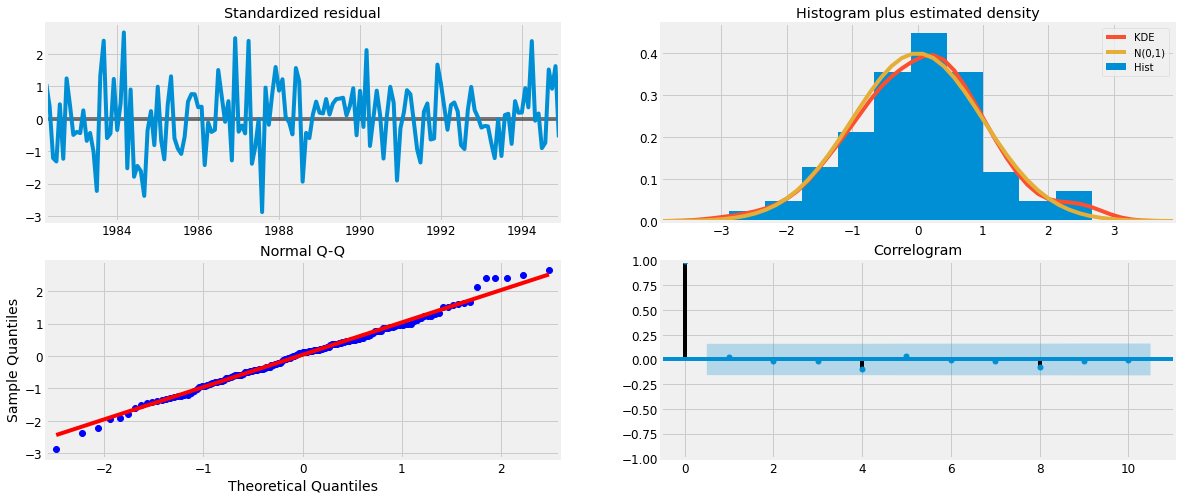

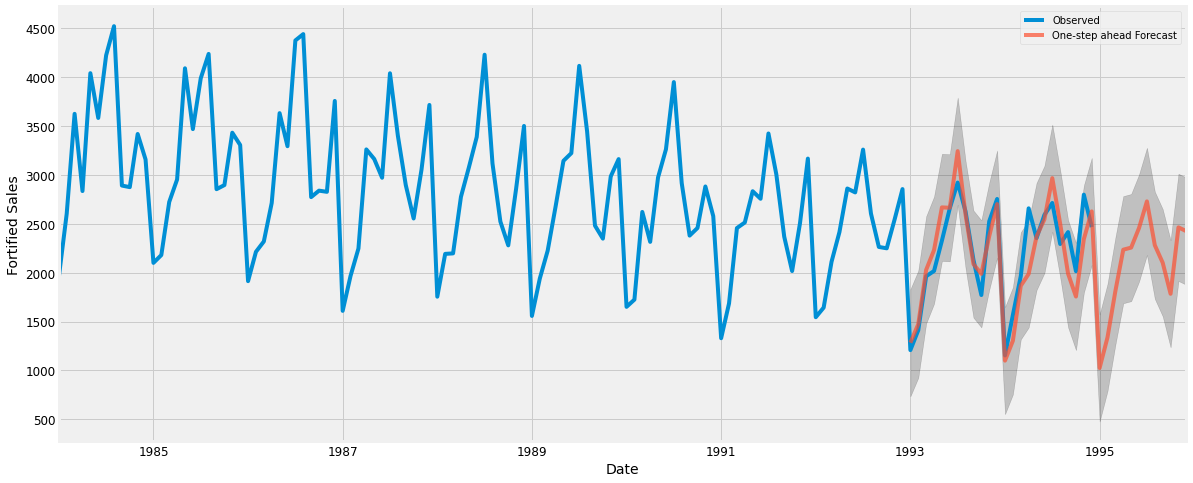

The Mean Squared Error of our forecasts is 116299.1
The Root Mean Squared Error of our forecasts is 341.03


In [10]:
Predicciones(y_fortified, (0,1,1), (1,1,1,12))


## Red

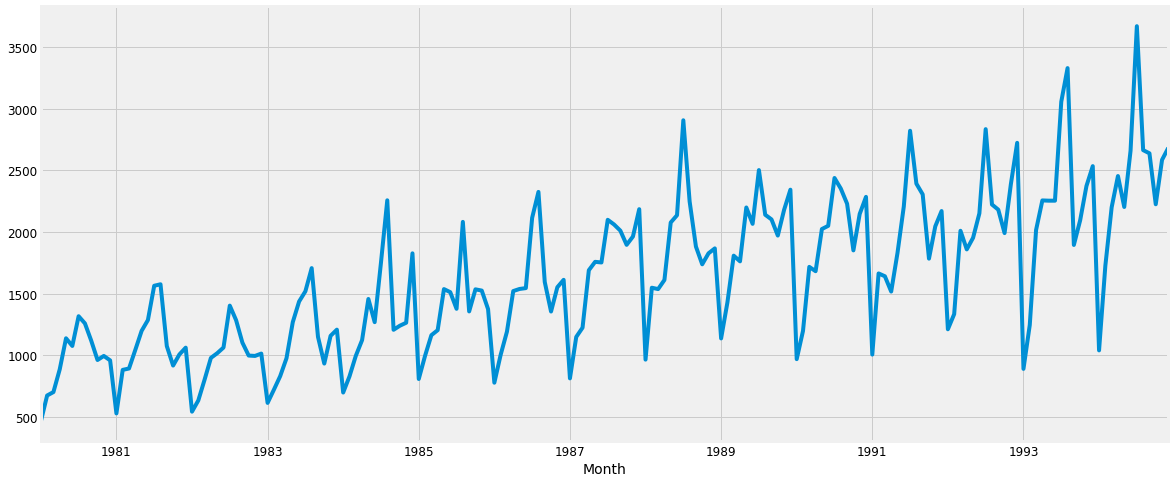

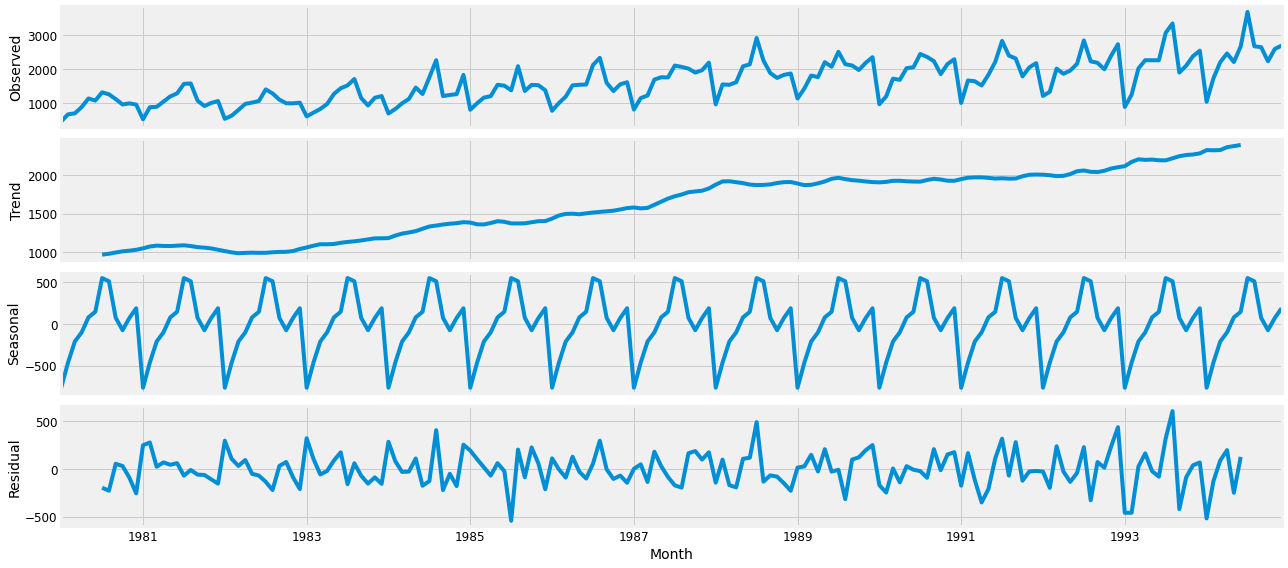

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2086.391382650295


In [11]:
y_red = Reordenamiento_Meses(red, 'Red ')
SARIMA_Param(y_red)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8846      0.036    -24.827      0.000      -0.954      -0.815
ma.S.L12      -0.6484      0.068     -9.526      0.000      -0.782      -0.515
sigma2      4.629e+04   4233.213     10.934      0.000     3.8e+04    5.46e+04


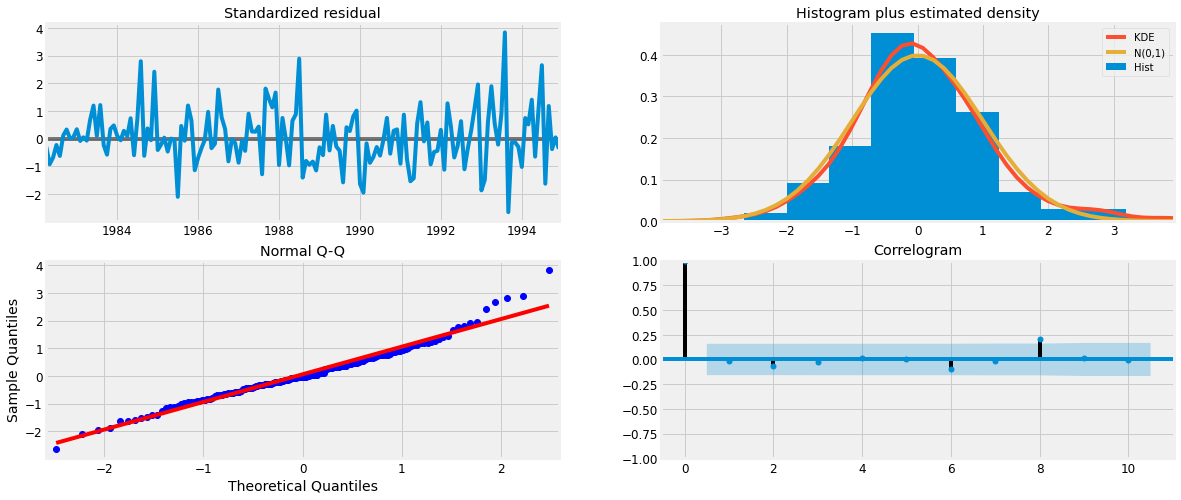

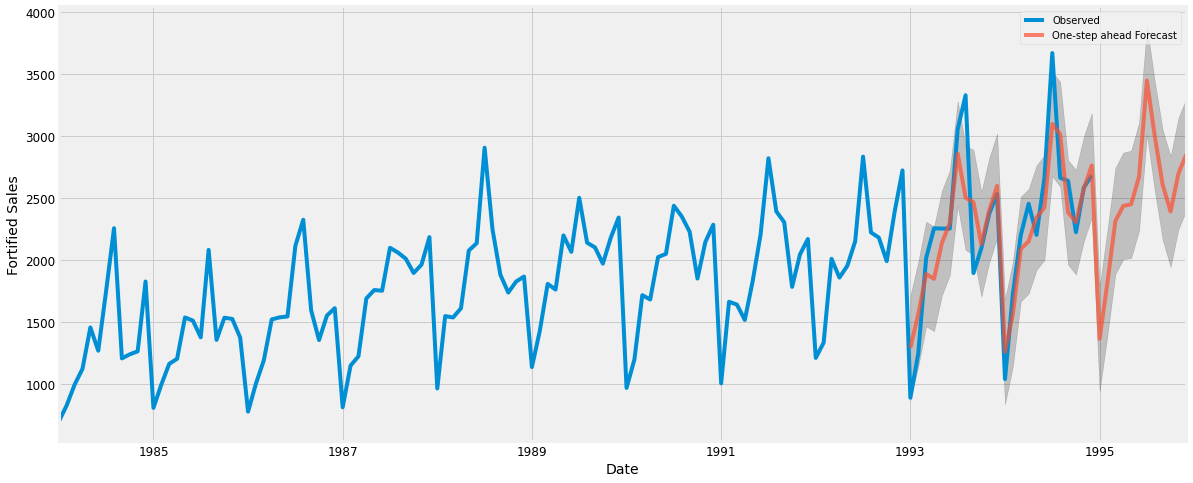

The Mean Squared Error of our forecasts is 68720.6
The Root Mean Squared Error of our forecasts is 262.15


In [12]:
Predicciones(y_red, (0,1,1), (0,1,1,12))


## Rose

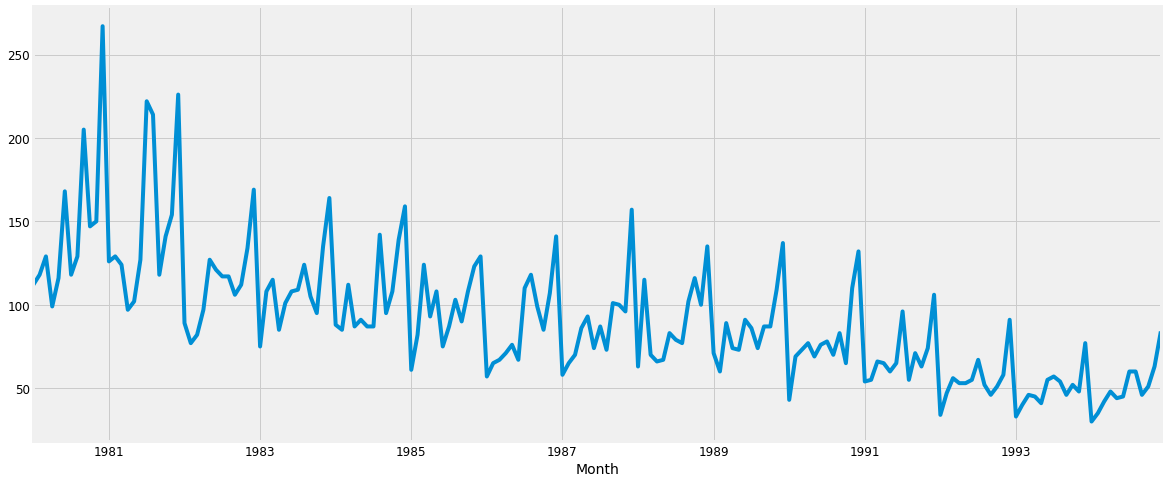

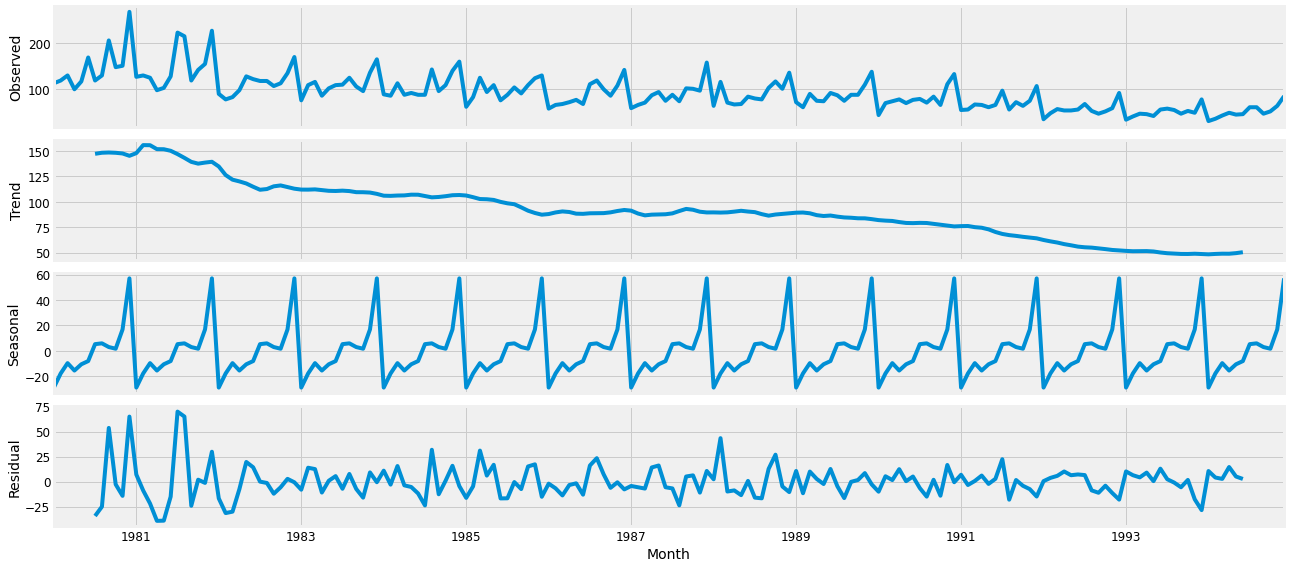

Minimo:  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1287.7963509551764


In [13]:
rose = Reemplazo_Asteriscos(rose, 'Rose ') # Se reemplazan asteriscos
y_rose = Reordenamiento_Meses(rose, 'Rose ')
SARIMA_Param(y_rose)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1836      0.079      2.327      0.020       0.029       0.338
ma.L1         -0.9159      0.040    -23.059      0.000      -0.994      -0.838
ma.S.L12      -0.5871      0.059    -10.031      0.000      -0.702      -0.472
sigma2       248.0831     25.651      9.672      0.000     197.808     298.358


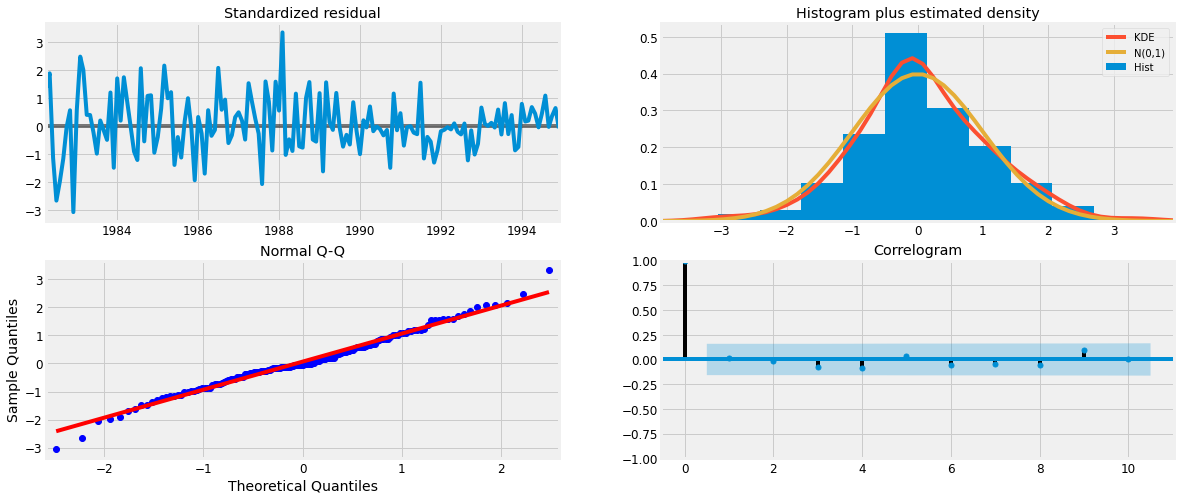

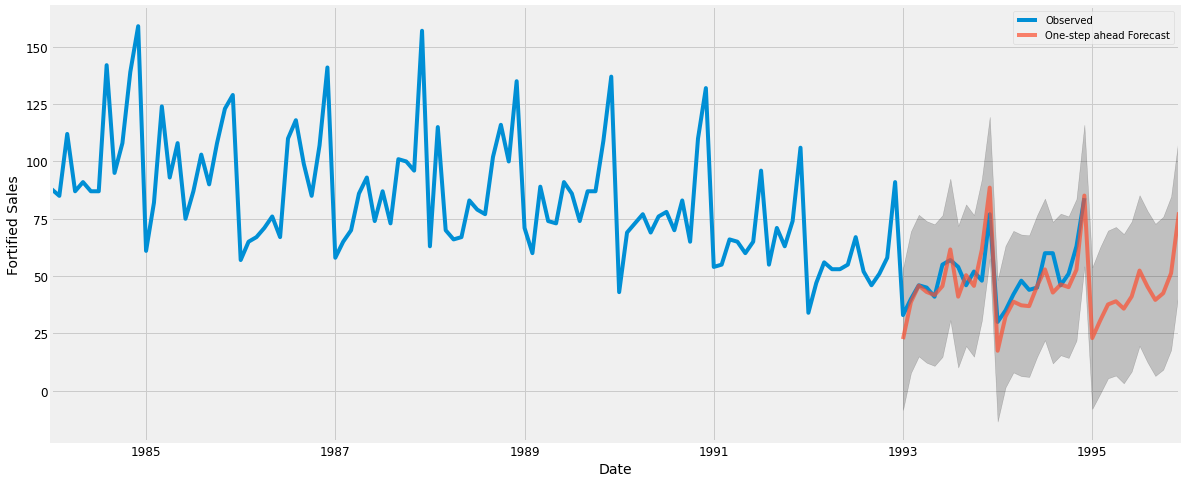

The Mean Squared Error of our forecasts is 6607518.05
The Root Mean Squared Error of our forecasts is 2570.51


In [14]:
Predicciones(y_rose, (1,1,1), (0,1,1,12))

## Sparkling

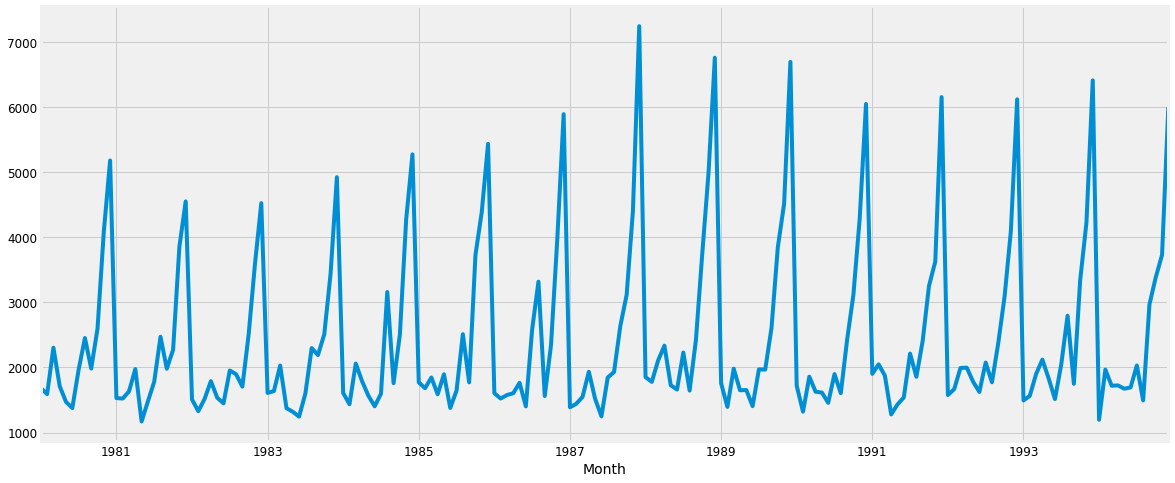

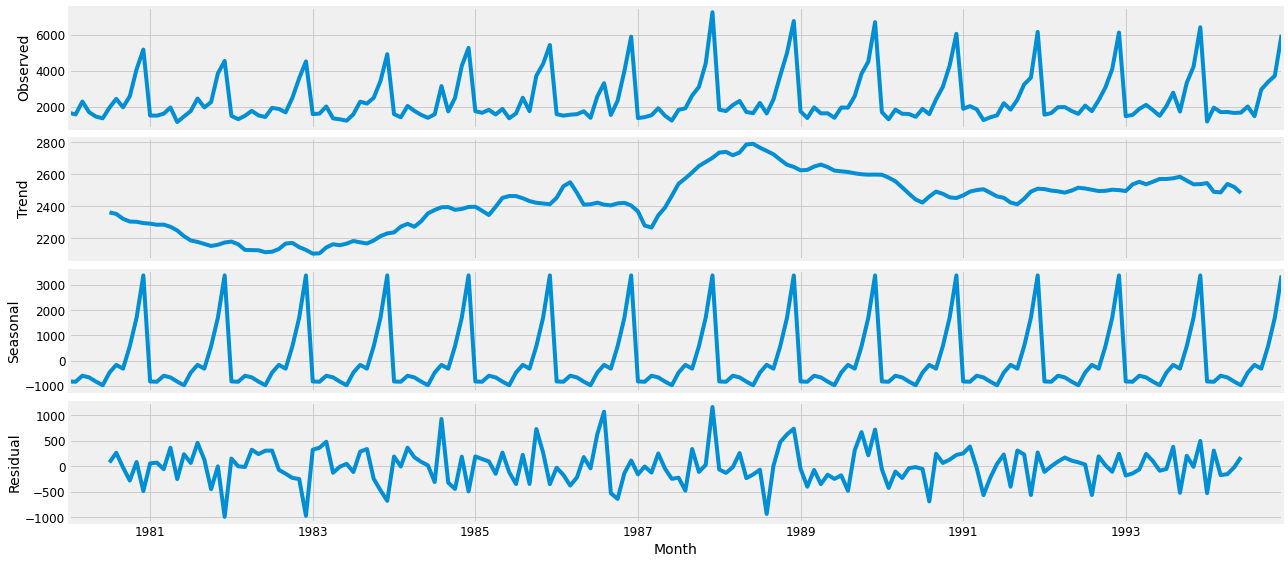

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2271.5217326848706


In [15]:
y_sparkling = Reordenamiento_Meses(sparkling, 'sparkling ')
SARIMA_Param(y_sparkling)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0728      0.040    -26.801      0.000      -1.151      -0.994
ma.S.L12      -0.5847      0.055    -10.687      0.000      -0.692      -0.477
sigma2      1.353e+05   1.39e+04      9.768      0.000    1.08e+05    1.63e+05


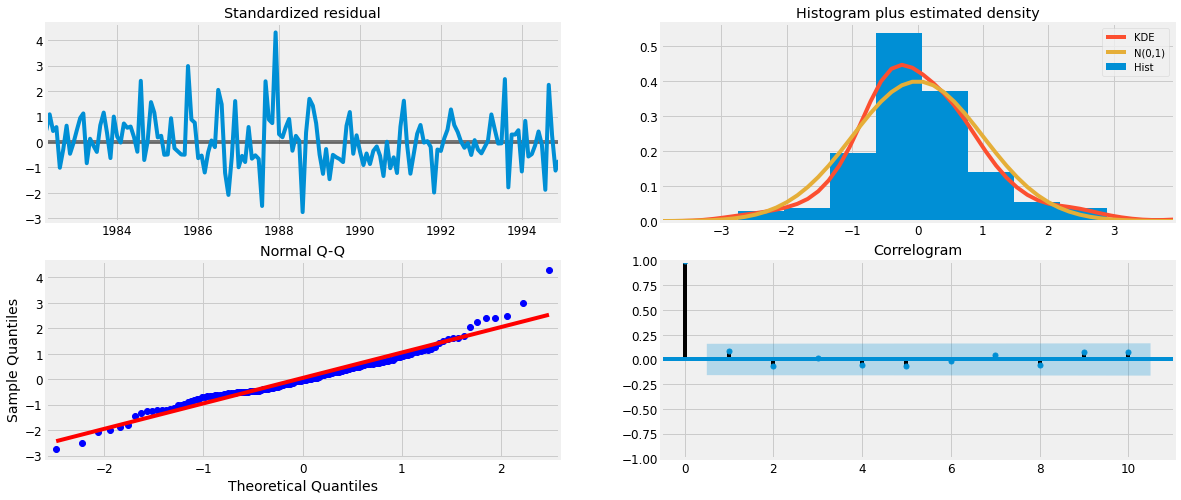

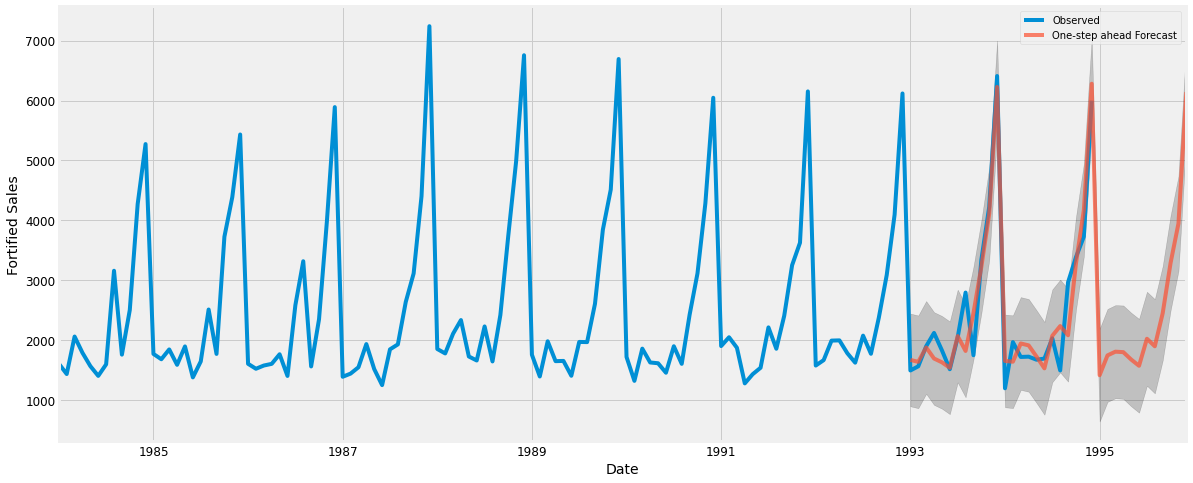

The Mean Squared Error of our forecasts is 8216767.43
The Root Mean Squared Error of our forecasts is 2866.49


In [16]:
Predicciones(y_sparkling,(0, 1, 1),(0, 1, 1, 12))

## Sweet white

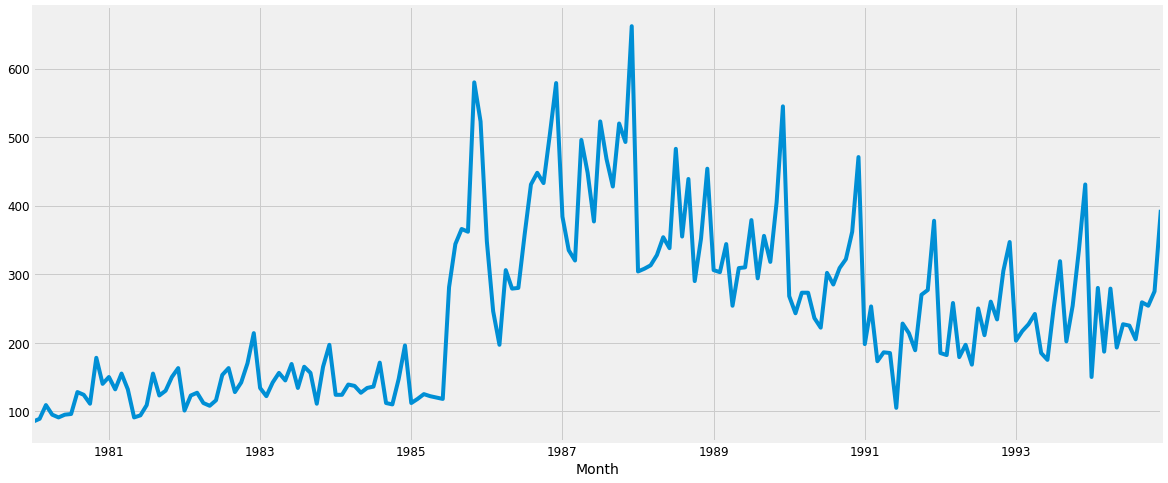

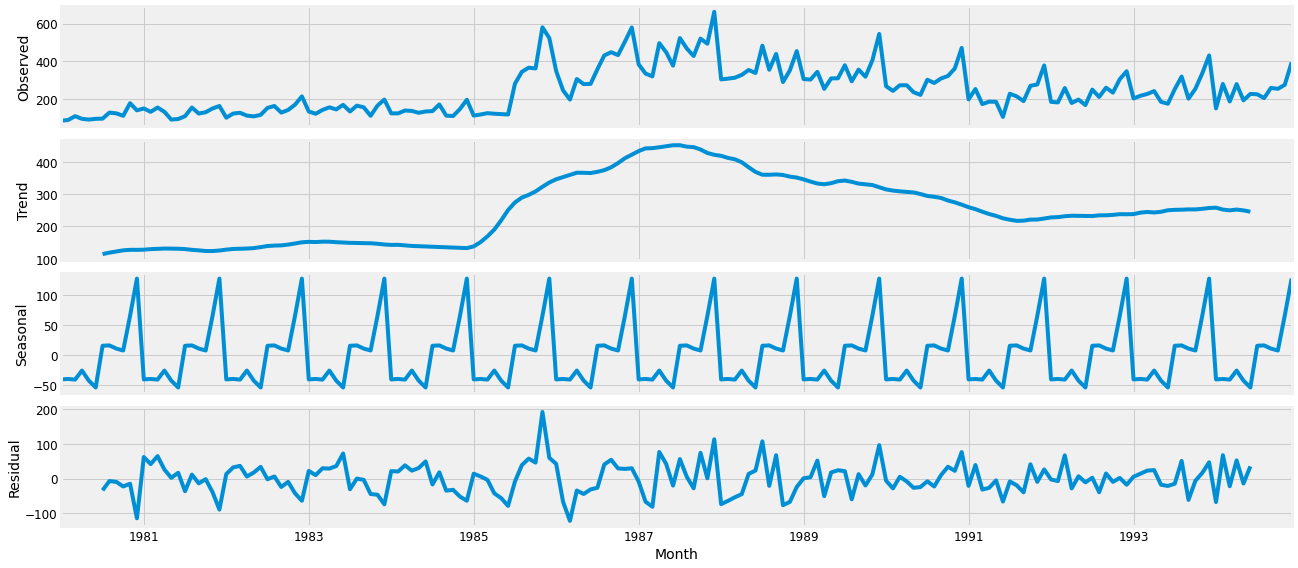

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1671.9867567083738


In [17]:
y_sweet_white = Reordenamiento_Meses(sweet_white, 'Sweet white')
SARIMA_Param(y_sweet_white)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3687      0.125     -2.951      0.003      -0.614      -0.124
ma.L1         -0.1500      0.128     -1.173      0.241      -0.401       0.101
ar.S.L12       0.2326      0.076      3.057      0.002       0.083       0.382
ma.S.L12      -1.0000      0.097    -10.287      0.000      -1.191      -0.809
sigma2      2522.6391   3.85e-05   6.55e+07      0.000    2522.639    2522.639


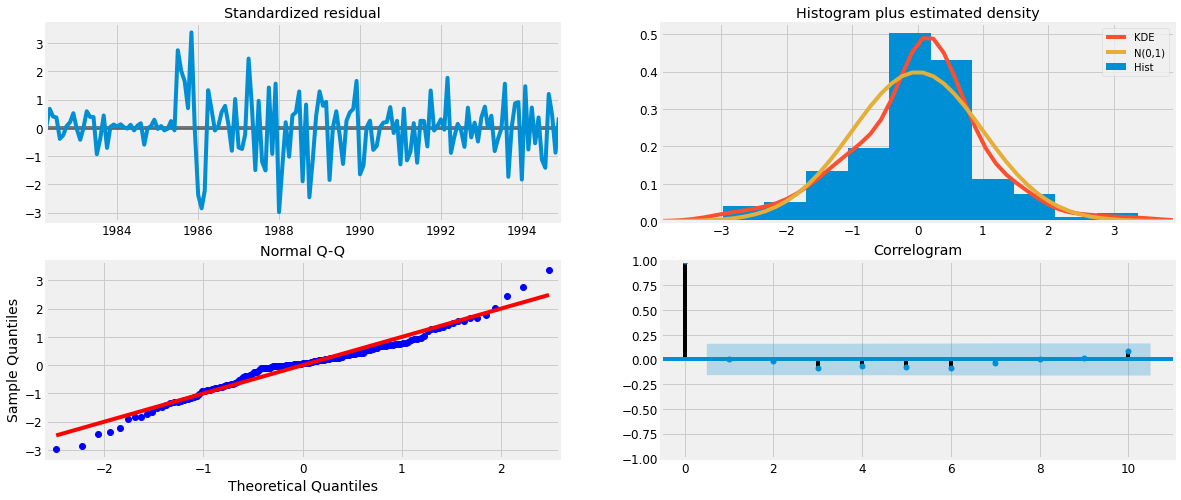

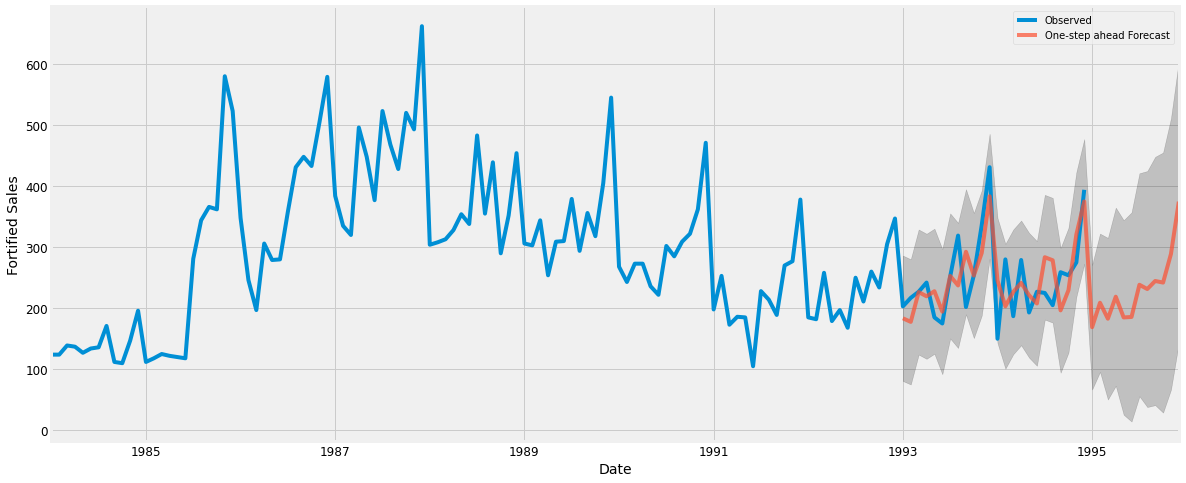

The Mean Squared Error of our forecasts is 5259613.46
The Root Mean Squared Error of our forecasts is 2293.38


In [18]:
Predicciones(y_sweet_white,(1, 1, 1),(1, 1, 1, 12))

## Dry white

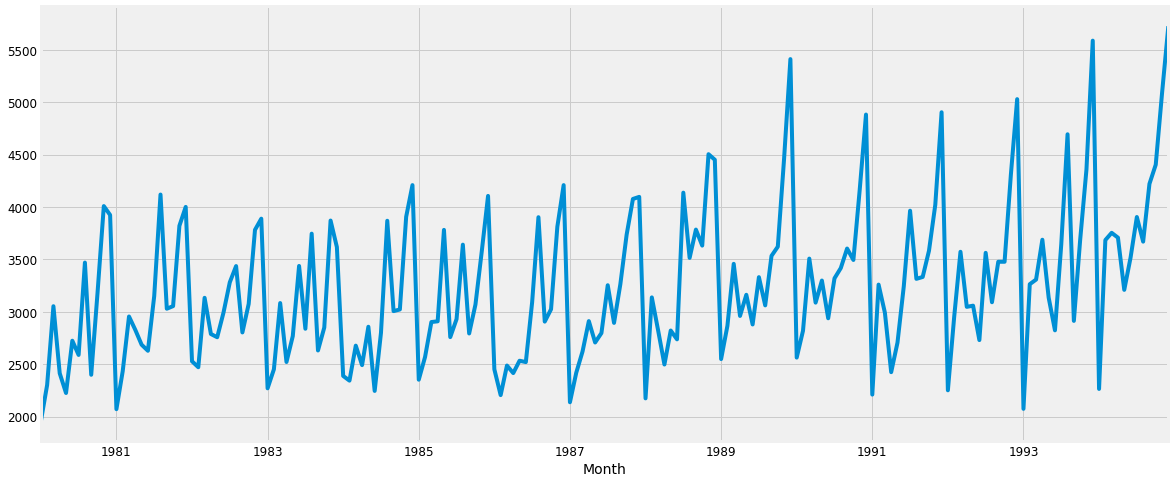

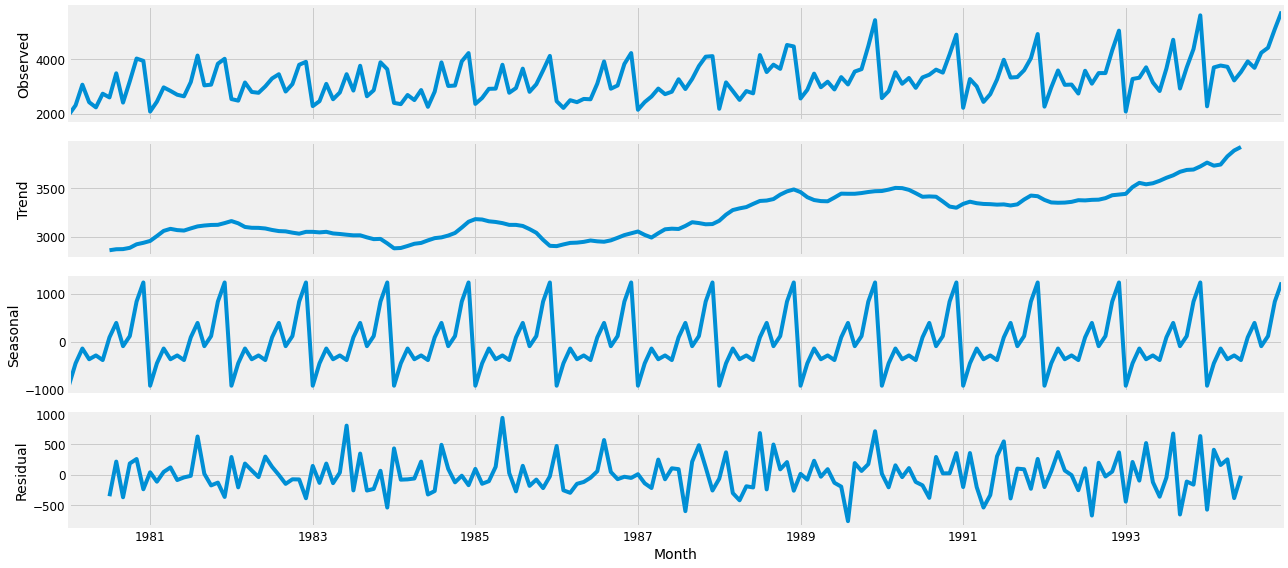

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2233.242568479068


In [19]:
y_dry_white = Reordenamiento_Meses(dry_white, 'Dry white')
SARIMA_Param(y_dry_white)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8653      0.049    -17.746      0.000      -0.961      -0.770
ma.S.L12      -0.6713      0.064    -10.457      0.000      -0.797      -0.545
sigma2      1.209e+05   1.13e+04     10.739      0.000    9.88e+04    1.43e+05


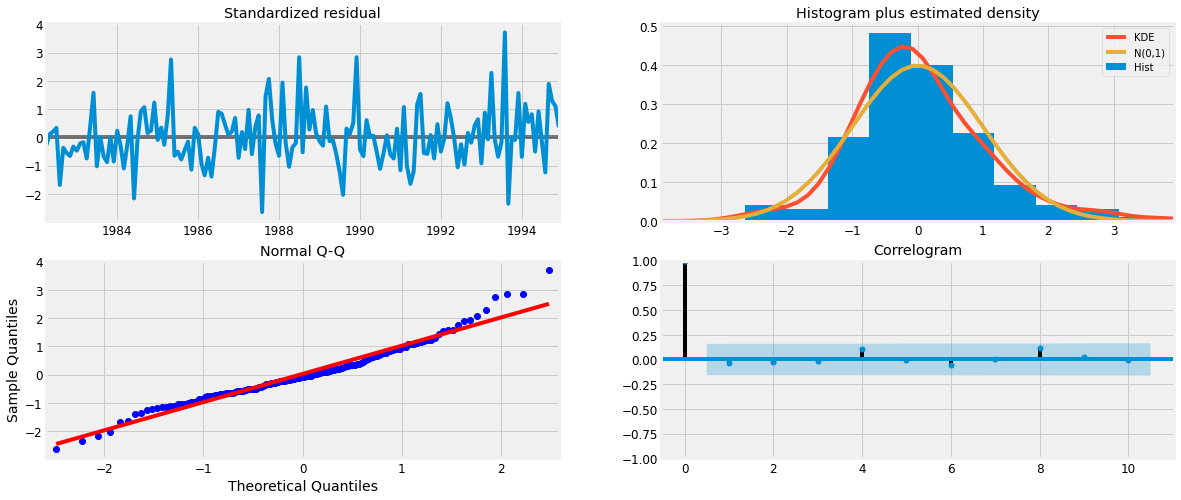

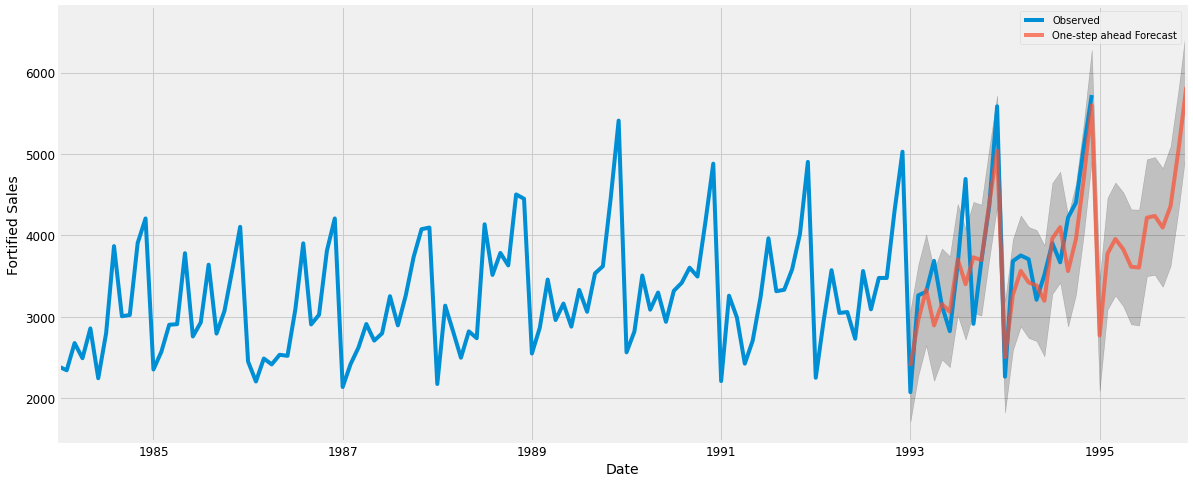

The Mean Squared Error of our forecasts is 6718995.45
The Root Mean Squared Error of our forecasts is 2592.1


In [20]:
Predicciones(y_dry_white,(0, 1, 1),(0, 1, 1, 12))

# 2.2: Desempeño de pronosticos dado conjuntos de entrenamiento y validación

## Funciones:

In [21]:
def Cjts_Training_Val(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  # Partition into train and validation set
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  Training_Pred = results.get_prediction(end = -12*Year_Obj, dynamic=False)
  Training_Pred_ci = Training_Pred.conf_int(alpha=0.2)
  Val_Pred = results.get_prediction(start = -12*Year_Obj,end = len(y_fortified) + 11, dynamic=False)
  Val_Pred_ci = Val_Pred.conf_int(alpha=0.2)
  if Plot:
    ax = Y_Obj['1984':].plot(label='Observed')
    Val_Pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Val_Pred_ci.index,
                    Val_Pred_ci.iloc[:, 0],
                    Val_Pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
    y_forecasted = Val_Pred.predicted_mean
    y_truth = Y_Obj['1994-11-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
  return Training_Pred,Training_Set, Val_Pred, Val_Set, Val_Pred_ci, Training_Pred_ci

In [22]:
def summary_performance(expected,predictions):
  forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
  bias = sum(forecast_errors)*1.0/len(expected)
  mae = mean_absolute_error(expected, predictions)
  mse = mean_squared_error(expected, predictions)
  rmse = sqrt(mse)
  print(tabulate([['Bias:',bias], ['MAE:',mae], ['MSE:',mse], ['RMSE:',rmse]], headers=['Measure', 'Num'], tablefmt='orgtbl'))

In [27]:
def Cjts_performance(conjunto, wine_name, conjunto_name):
  # For training set performance create lagged ts
  conjunto_lag2 = conjunto.shift(-2, fill_value=0)
  conjunto_lag12 = conjunto.shift(-12, fill_value=0)
  
  # Calculate residuals
  resids_conjunto_lag2 = conjunto - conjunto_lag2
  resids_conjunto_lag12 = conjunto - conjunto_lag12
  
  # Training set accuracy
  print('Accuracy Stats '+wine_name+' Wine Forecast over '+conjunto_name+' Set \n')
  summary_performance(conjunto,conjunto_lag2)

  print('\n')
  
  # Training set accuracy of Seasonal
  print('Accuracy Stats for Seasonal '+wine_name+' Wine over '+conjunto_name+' Set \n')
  summary_performance(conjunto,conjunto_lag2)

  print('\n')

  # Naive and Seasonal Naive plots
  plt.plot(resids_conjunto_lag2)
  plt.ylabel('Residuals')
  plt.xlabel('Month')
  plt.title('Error in Naive Forecast \n on the '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()
  
  print('\n')
  
  plt.plot(resids_conjunto_lag12)
  plt.ylabel('Residuals')
  plt.xlabel('Month')
  plt.title('Error in Seasonal Naive Forecast \n on the '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()

  print('\n')

  # Histograms of residuals
  
  H, B = np.histogram(resids_conjunto_lag2, bins=10)
  width = 0.7*(B[1]-B[0])
  center = (B[:-1]+B[1:])/2
  plt.bar(center, H, align='center', width=width)
  plt.ylabel('Frequency')
  plt.xlabel('Reduals')
  plt.title('Error in Naive Forecast \n on the '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()
  
  print('\n')

  H, B = np.histogram(resids_conjunto_lag12, bins=10)
  width = 0.7*(B[1]-B[0])
  center = (B[:-1]+B[1:])/2
  plt.bar(center, H, align='center', width=width)
  plt.ylabel('Frequency')
  plt.xlabel('Reduals')
  plt.title('Error in Seasonal Naive Forecast \n on the '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()

## Fortified

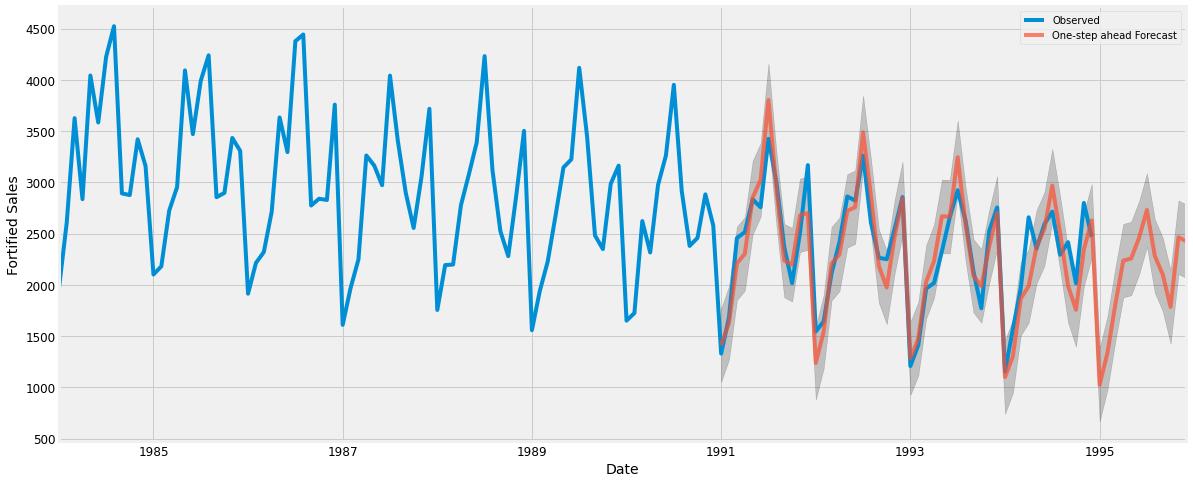

The Mean Squared Error of our forecasts is 116299.1
The Root Mean Squared Error of our forecasts is 341.03


In [25]:
Training_Pred_Fortified, Training_Fortified, Val_Pred_Fortified,Val_Fortified, Val_Pred_CI, Training_Pred_CI= Cjts_Training_Val(y_fortified, (0,1,1), (1,1,1,12), 4,True)

Accuracy Stats Fortified Wine Forecast over Training Set 

| Measure   |           Num |
|-----------+---------------|
| Bias:     |   45.0985     |
| MAE:      |  930.417      |
| MSE:      |    1.1561e+06 |
| RMSE:     | 1075.22       |


Accuracy Stats for Seasonal Fortified Wine over Training Set 

| Measure   |           Num |
|-----------+---------------|
| Bias:     |   45.0985     |
| MAE:      |  930.417      |
| MSE:      |    1.1561e+06 |
| RMSE:     | 1075.22       |




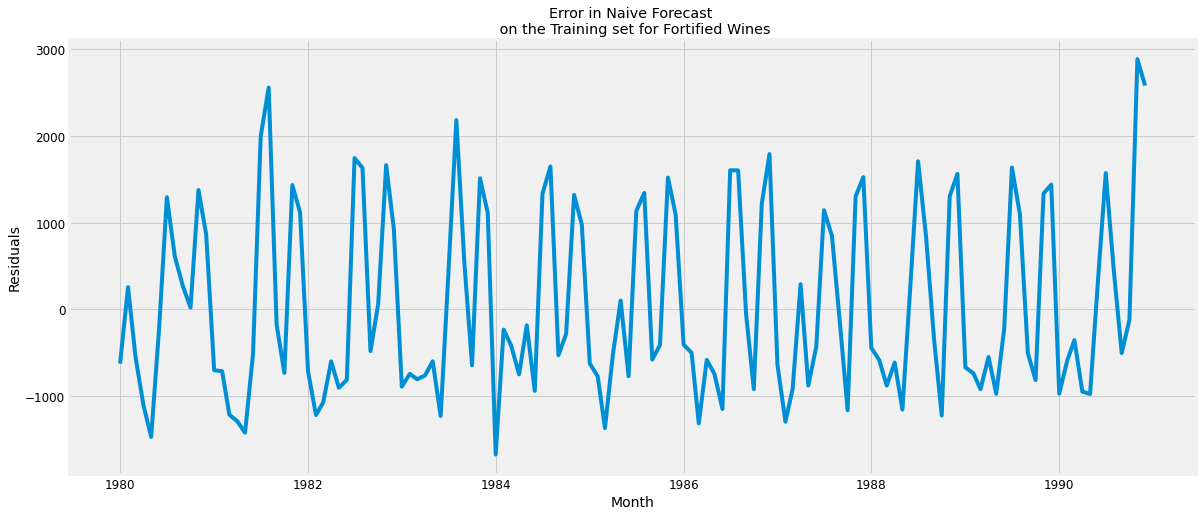

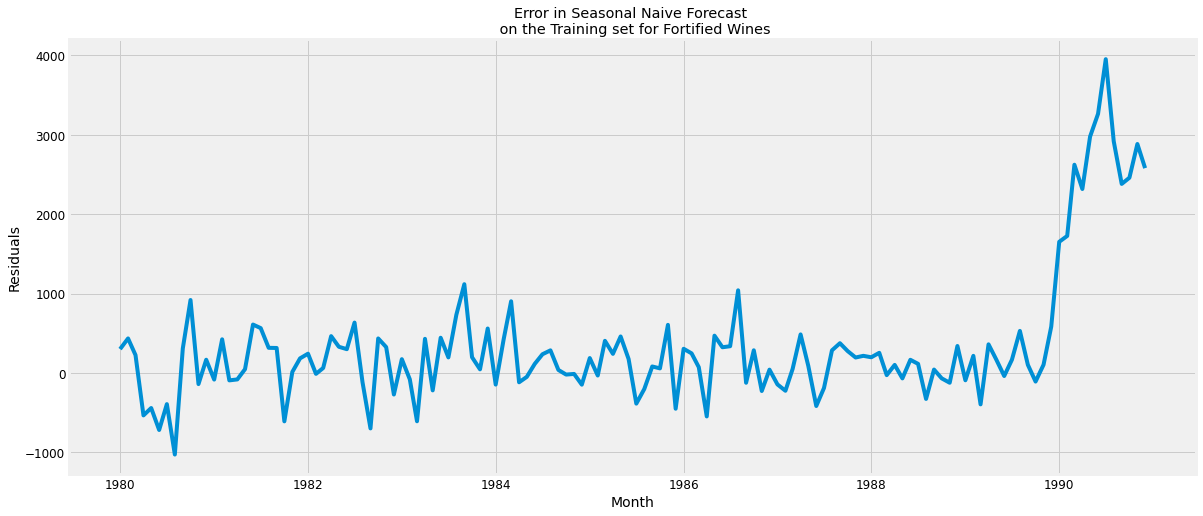

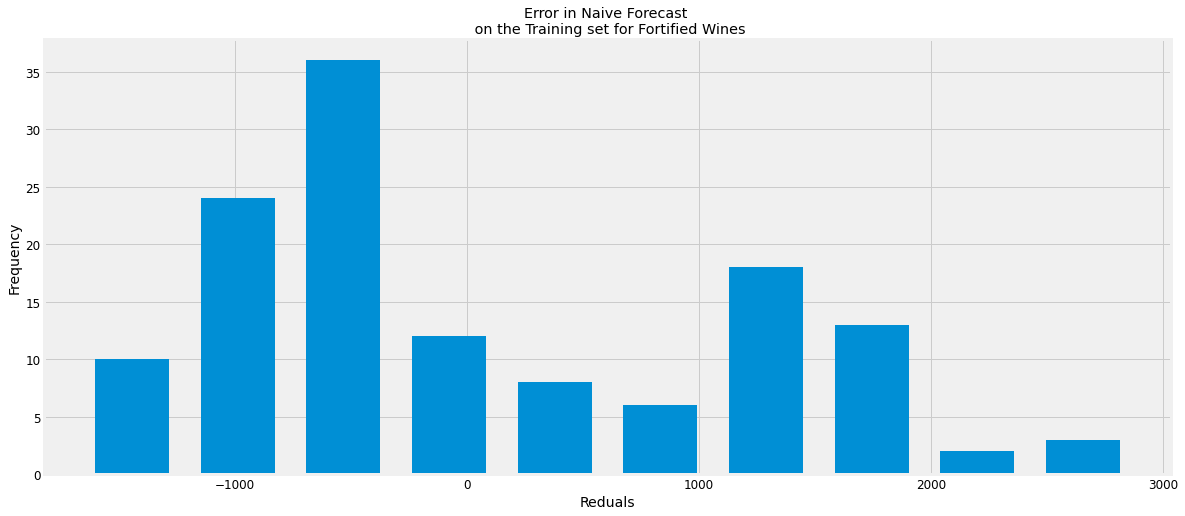

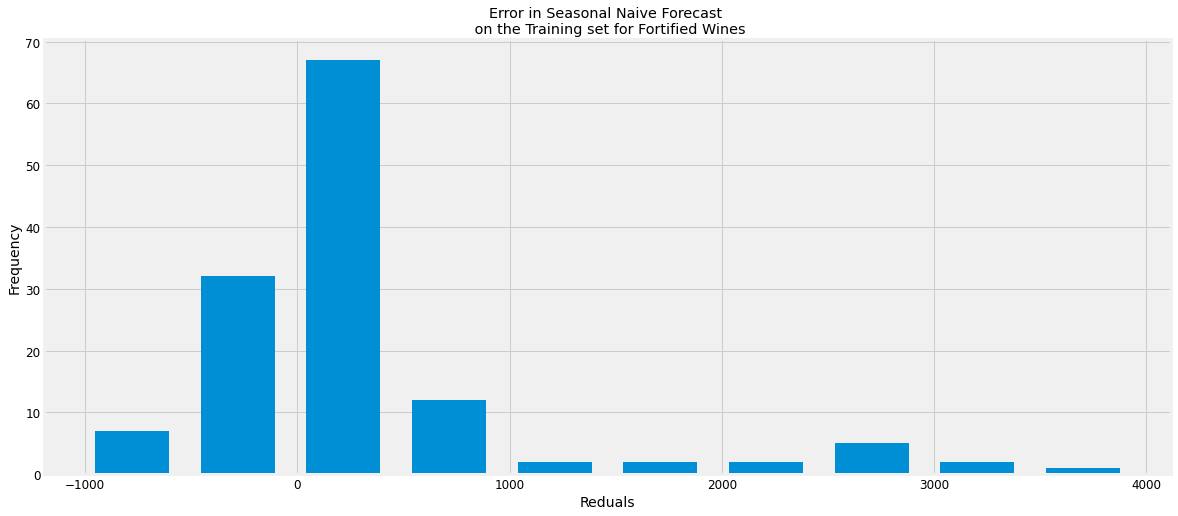

In [28]:
Cjts_performance(Training_Fortified,'Fortified', 'Training')

Accuracy Stats Fortified Wine Forecast over Validation Set 

| Measure   |         Num |
|-----------+-------------|
| Bias:     |     62.8333 |
| MAE:      |    742.417  |
| MSE:      | 850200      |
| RMSE:     |    922.063  |


Accuracy Stats for Seasonal Fortified Wine over Validation Set 

| Measure   |         Num |
|-----------+-------------|
| Bias:     |     62.8333 |
| MAE:      |    742.417  |
| MSE:      | 850200      |
| RMSE:     |    922.063  |




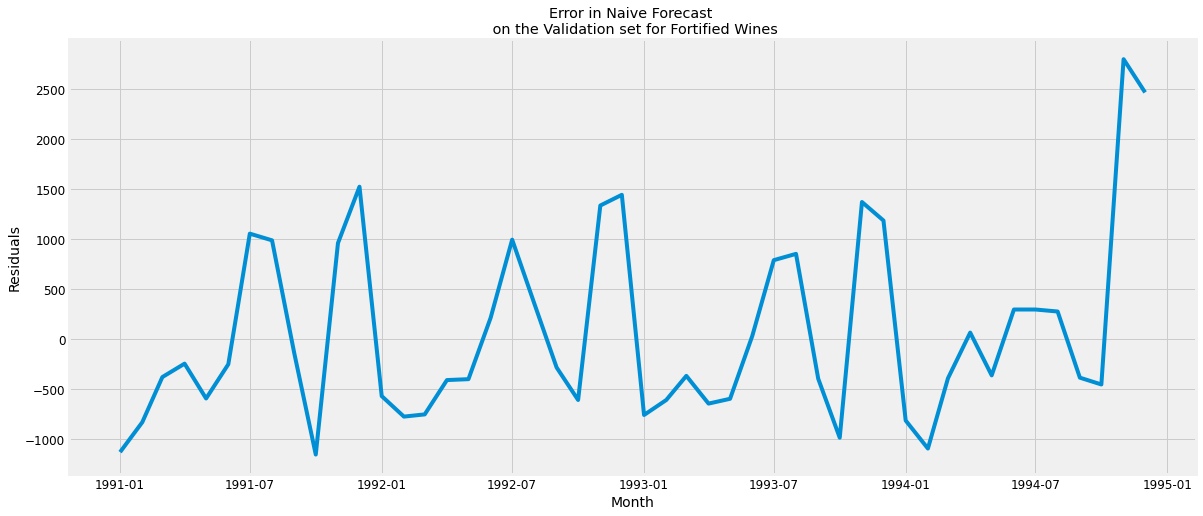

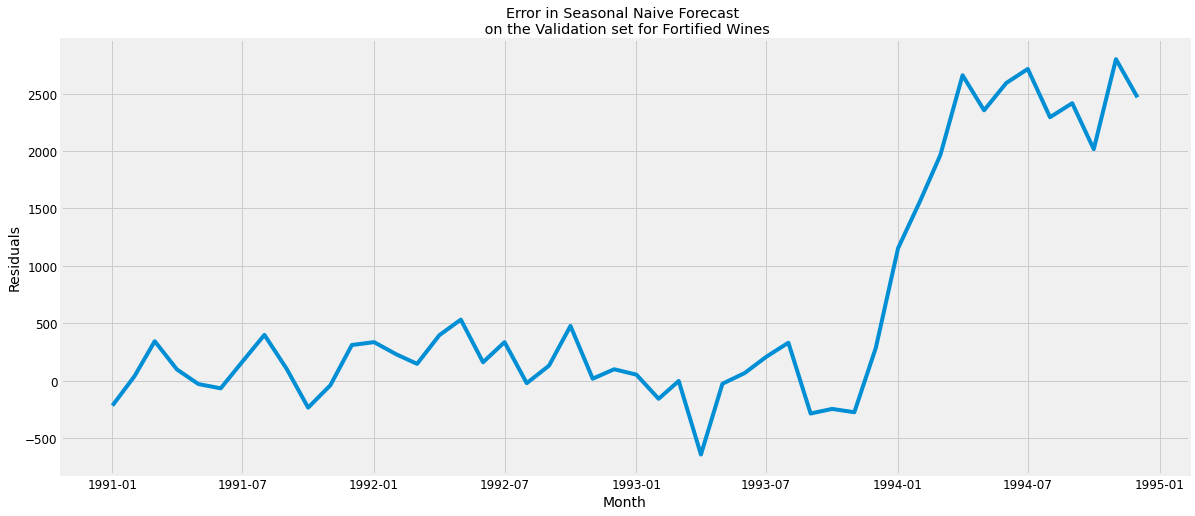

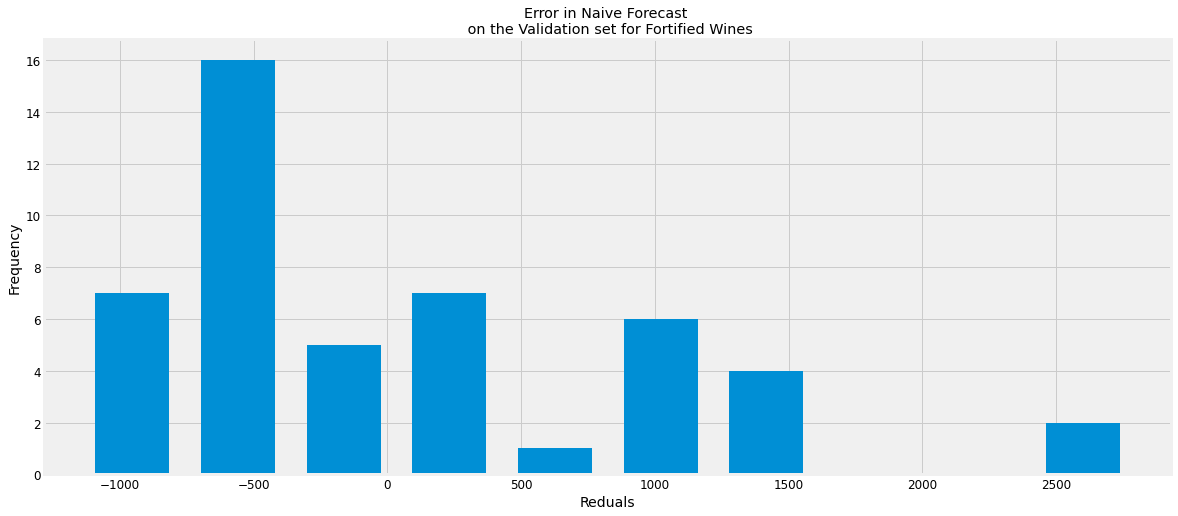

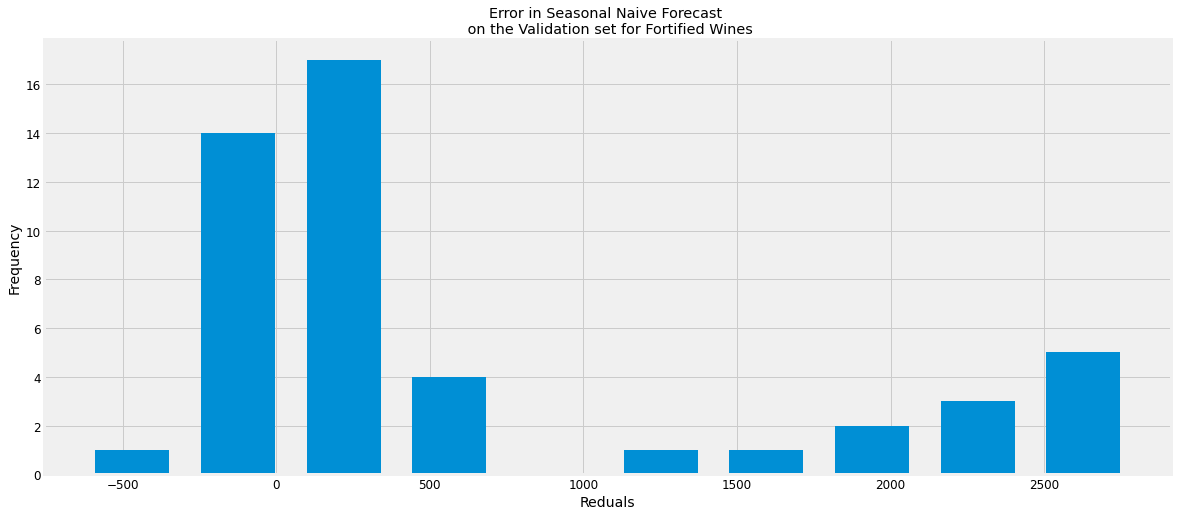

In [29]:
Cjts_performance(Val_Fortified,'Fortified','Validation')

# 2.3 Elegir uno o mas tipos de vinos

¡ELEGIR!

# 2.4 Calcular Pronosticos para los periodos de entrenamiento y validacion

## Funciones

In [30]:
def plot_forecast(y_obj,y_pred,y_pred_ci):
    ax = y_obj['1980':].plot(label='Observed')
    y_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(y_pred_ci.index,
                    y_pred_ci.iloc[:, 0],
                    y_pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
    y_forecasted = y_pred.predicted_mean
    y_truth = y_obj['1994-11-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

## Fortified

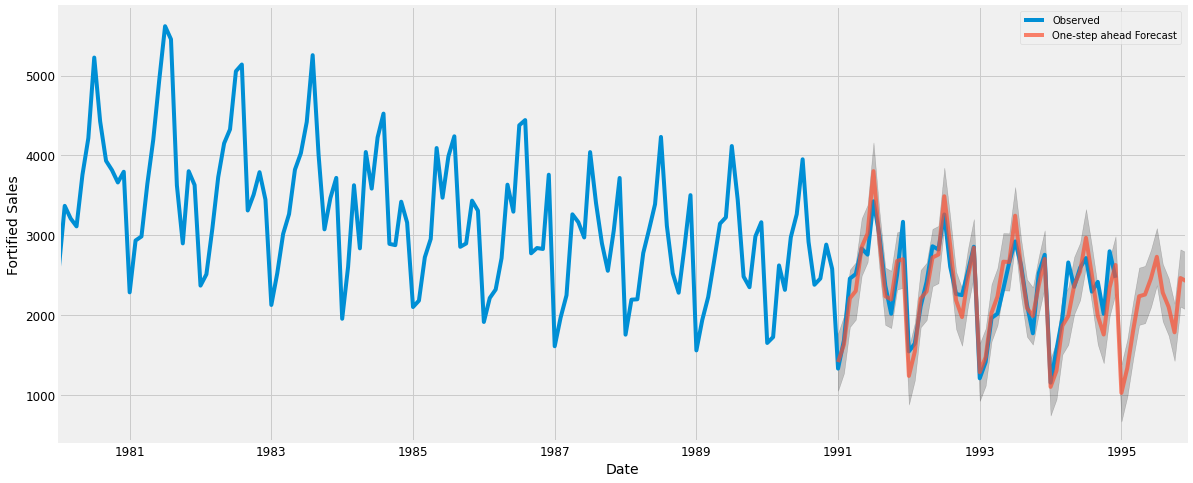

The Mean Squared Error of our forecasts is 116299.1
The Root Mean Squared Error of our forecasts is 341.03


In [31]:
plot_forecast(y_fortified,Val_Pred_Fortified,Val_Pred_CI)

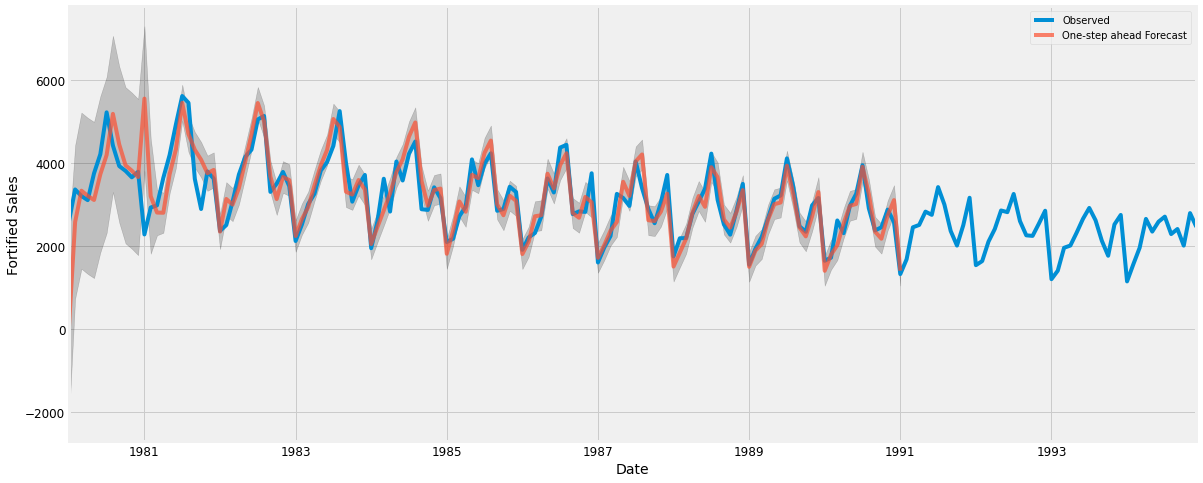

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan


In [32]:
# REVISAR ESTO!
plot_forecast(y_fortified,Training_Pred_Fortified,Training_Pred_CI)

# 2.5 2.6 no entender

# 2.7: Histograma e intervalo de confianza

## Funciones

In [37]:
def histograma(expected, prediction, wine_name):
  DataF = expected - prediction.predicted_mean[:-12]
  H, B = np.histogram(DataF, bins = 10)
  print(H, B)
  #print(DataF.hist(bins=10)) # La diferencia entre lo predicho y lo obtenido
  width = 0.7 * (B[1] - B[0])
  center = (B[:-1] + B[1:]) / 2
  plt.bar(center, H, align='center', width=width)
  plt.title('Histogram of Residuals of '+wine_name+' Forecast')
  plt.ylabel('Frequency')
  plt.xlabel('Residuos')
  plt.show()

## Fortified

[ 3  9  5  6 14  3  4  2  1  1] [-377.93565159 -273.04530806 -168.15496452  -63.26462099   41.62572254
  146.51606607  251.40640961  356.29675314  461.18709667  566.07744021
  670.96778374]


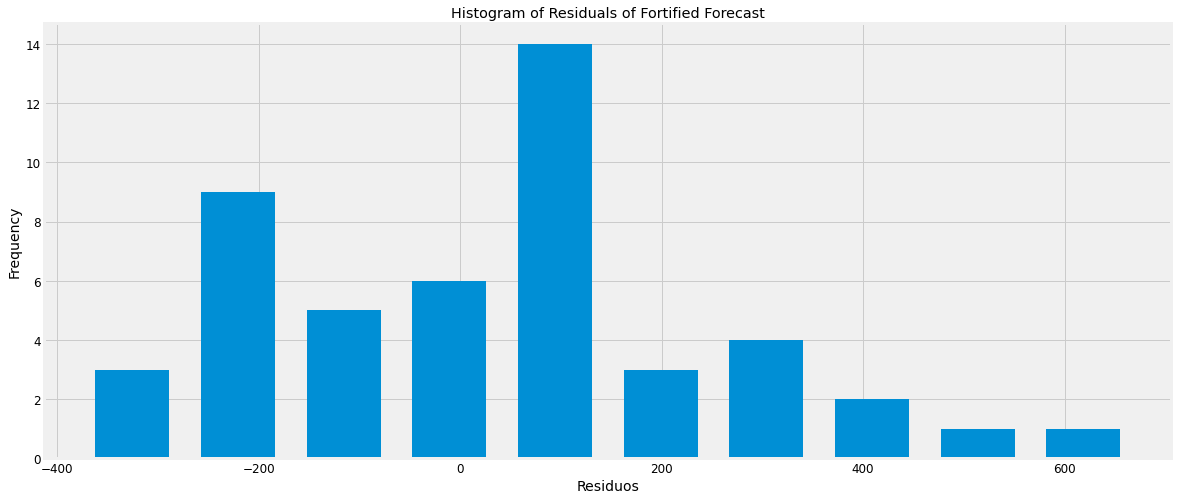

In [38]:
histograma(Val_Fortified, Val_Pred_Fortified, 'Fortified')

In [61]:
resids_rose = Val_Fortified - Val_Pred_Fortified.predicted_mean[:-12]
resids_rose.quantile([.1, .9])
#print(tabulate([['Bias:',bias], ['MAE:',mae], ['MSE:',mse], ['RMSE:',rmse]], headers=['Measure', 'Num'], tablefmt='orgtbl'))

0.1   -256.147418
0.9    284.644840
dtype: float64

# Ejemplo

In [ ]:
df = pd.read_excel("C:/Users/ascan/Downloads/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
furniture['Order Date'].min(), furniture['Order Date'].max()

In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
furniture = furniture.set_index('Order Date')
furniture.index

In [ ]:
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))